In [26]:
# NOTE: THIS IS NOT YET FINISHED. IMAGES NEED TO BE USED AS SOURCE. FILES ARE HELLA LARGE ALSO...


import h5py
import scipy.io as io
import PIL.Image as Image
import numpy as np
import os
import glob
from matplotlib import pyplot as plt
from scipy.ndimage.filters import gaussian_filter 
import scipy
import json
from matplotlib import cm as CM
import time
from datetime import datetime


%matplotlib inline

In [27]:
# Maybe windows specific
NWPU_path = os.path.join("D:\\", "OneDrive\\OneDrive - UvA\\ThesisData\\Datasets\\NWPU-Crowd") 

NWPU_mats_path = os.path.join(NWPU_path, "mats")
NWPU_images_base_path = os.path.join(NWPU_path, "NWPU-Crowd")
NWPU_densities_path = os.path.join(NWPU_path, "gt-densities")
if not os.path.exists(NWPU_densities_path):
    os.mkdir(NWPU_densities_path)

In [40]:
def generate_density(img, mat, sigma):
    """ Given an image, its corresponding ground-truth annotated file, and a standard deviation, creates the ground-truth density map.
        img: The image corresponding to the ground-truth annotations
        mat: The coordinates of the annotations.
        sigma: A constant sigma used for the gaussian filter."""
    
    h, w, _ = img.shape
    k = np.zeros((h, w))
    
    gt_points = mat["annPoints"]  # Specific to NWPU-crowd
    for (x, y) in gt_points.astype(int):
        if x < w and y < h:
            k[y, x] = 1  # Note the order of x and y here. Height is stored in first dimension
        else:
            print("This should never happen!")  # This would mean a head is annotated outside the image.
    
    density = scipy.ndimage.filters.gaussian_filter(k, sigma, mode='constant')  
    return density

In [41]:
# TODO: IMAGES MUST SERVE AS BASE!!!
def gen_all_densities(gt_source_path, image_source_path, density_save_path, sigma):
    """ Looks for all files in the gt_source_path directory. For each file, retrieve the corresponding image file and generate a ground-truth 
        density map. This density map is saved in the given density_save_path. A constant sigma is used for the gaussian filter for all images."""
    
    files = os.listdir(gt_source_path)
    n_files = len(files)
    
    now = datetime.now().strftime("%d/%m/%Y %H:%M:%S")
    info_file_path = os.path.join(density_save_path, "info.txt")
    with open(info_file_path, 'w') as f:
        f.write(f"Densities generated with a constant sigma of {sigma}.\n")
        f.write(f"gt source dir: {gt_source_path}, image source dir: {image_source_path}, save dir: {density_save_path}\n")
        f.write(f"Generated on {now}\n")

    print("Generating ground truth density maps.")
    start_time = time.time()
    for i, gt_file in enumerate(files):
        if i > 5:
            return
        img_file = gt_file.replace(".mat", ".jpg")
        density_file = gt_file.replace(".mat", ".h5")

        gt_file_path = os.path.join(gt_source_path, gt_file)
        img_file_path = os.path.join(image_source_path, img_file)
        density_file_path = os.path.join(density_save_path, density_file)

        mat = io.loadmat(gt_file_path)
        img = plt.imread(img_file_path)

        density = generate_density(img, mat, sigma)

        with  h5py.File(density_file_path, 'w') as f:
            f['density'] = density

        seconds_passed = time.time() - start_time
        if seconds_passed > 1:
            start_time = time.time()
            print(f"{i + 1} of {n_files} density maps created.")
              
    print(f"All {n_files} density maps created.")

In [42]:
# Set sigma to a desired value
sigma = 5

In [43]:
NWPU_images_path = os.path.join(NWPU_images_base_path, "images_part1")
gen_all_densities(NWPU_mats_path, NWPU_images_path, NWPU_densities_path, sigma)

Generating ground truth density maps.
1 of 3609 density maps created.
4 of 3609 density maps created.
5 of 3609 density maps created.


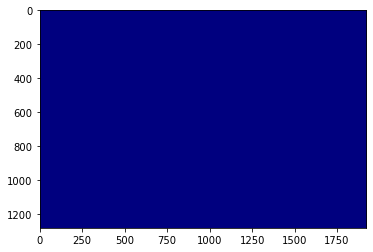

In [46]:
density_path = os.path.join(NWPU_densities_path, "0002.h5")
gt_file = h5py.File(density_path,'r')
groundtruth = np.asarray(gt_file['density'])
plt.imshow(groundtruth,cmap=CM.jet)
